In [1]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Configuración matplotlib
# ==============================================================================
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

# Varios
# ==============================================================================
from tqdm import tqdm

In [2]:
# Datos
# ==============================================================================
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-con-R/' \
      + 'master/datos/AfterSchool.csv'
datos = pd.read_csv(url)
datos = datos[['Treatment', 'Delinq']]
datos = datos.rename(columns={'Treatment': 'grupo', 'Delinq': 'valor'})
datos['grupo'] = np.where(datos['grupo'] == 0, 'control', 'tratamiento')
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356 entries, 0 to 355
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   grupo   356 non-null    object 
 1   valor   356 non-null    float64
dtypes: float64(1), object(1)
memory usage: 5.7+ KB


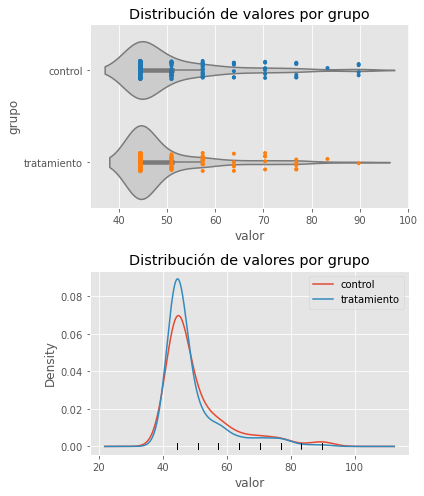

In [5]:
# Gráficos distribución observada
# ==============================================================================
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(6, 7))
sns.violinplot(
    x     = datos.valor,
    y     = datos.grupo,
    color = ".8",
    ax    = axs[0]
)
sns.stripplot(
    x    = datos.valor,
    y    = datos.grupo,
    data = datos,
    size = 4,
    jitter  = 0.1,
    palette = 'tab10',
    ax = axs[0]
)
axs[0].set_title('Distribución de valores por grupo')
axs[0].set_ylabel('grupo')
axs[0].set_xlabel('valor');

for grupo in datos.grupo.unique():
    datos_temp = datos[datos.grupo == grupo]['valor']
    datos_temp.plot.kde(ax=axs[1], label=grupo)
    axs[1].plot(datos_temp, np.full_like(datos_temp, 0), '|k', markeredgewidth=1)

axs[1].set_title('Distribución de valores por grupo')
axs[1].set_xlabel('valor');
axs[1].legend()

fig.tight_layout();

In [6]:
# Estadísticos descriptivos por grupo
# ==============================================================================
datos.groupby(by='grupo').describe()

valor                                                        \
             count       mean       std        min        25%        50%   
grupo                                                                      
control      187.0  50.725591  10.52089  44.463082  44.463082  44.463082   
tratamiento  169.0  49.018956   8.97423  44.463082  44.463082  44.463082   

                                   
                   75%        max  
grupo                              
control      50.933188  89.753823  
tratamiento  50.933188  89.753823

In [7]:
def dif_mean(x1, x2):
    '''
    Función para calcular la diferencia de medias entre dos grupos.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    
    estadistico = np.mean(x1) - np.mean(x2)
    return(estadistico)

In [8]:
dif_observada = dif_mean(
                    x1 = datos[datos.grupo == 'control']['valor'],
                    x2 = datos[datos.grupo == 'tratamiento']['valor']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: 1.7066355191972207


In [9]:
def permutaciones(x1, x2, fun_estadistico, n_iteraciones=9999):
    '''
    Función para calcular el valor del estadístico en múltiples permutaciones
    de dos muestras.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
 
    fun_estadistico : function
        función que recibe como argumento las dos muestras y devuelve el valor
        del estadístico.
        
    n_iteraciones : int
        número de permutaciones calculadas (default `9999`).
        
    Returns
    -------
    distribuciones: numpy array
        valor del estadístico en cada permutación.
    '''
    
    n_x1 = len(x1)
    n_x2 = len(x2)
    pool_datos = np.hstack((x1, x2))
    
    resulados_permutaciones = np.full(shape=n_iteraciones, fill_value=np.nan)
    
    for i in tqdm(range(n_iteraciones)):
        np.random.shuffle(pool_datos)
        estadistico = fun_estadistico(pool_datos[:n_x1], pool_datos[n_x1:])
        resulados_permutaciones[i] = estadistico
        
    return resulados_permutaciones

In [10]:
dist_permut = permutaciones(
                x1 = datos[datos.grupo == 'control']['valor'],
                x2 = datos[datos.grupo == 'tratamiento']['valor'],
                fun_estadistico = dif_mean,
                n_iteraciones   = 9999
              )

100%|██████████| 9999/9999 [00:00<00:00, 53345.23it/s]


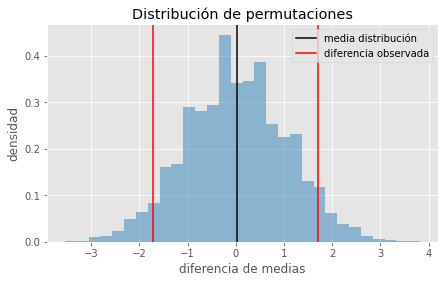

In [11]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de medias')
ax.set_ylabel('densidad')
ax.legend();

In [12]:
pd.Series(dist_permut).describe()

count    9999.000000
mean        0.020336
std         1.047187
min        -3.541023
25%        -0.698541
50%         0.030300
75%         0.759142
max         3.820276
dtype: float64

In [13]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.11011101110111012
p-value con corrección: 0.11021102110211022


In [15]:
def dif_var(x1, x2):
    '''
    Función para calcular la diferencia de varianzas entre dos muestras.
    
    Parameters
    ----------
    x1 : numpy array
         valores de la muestra 1.
         
    x2 : numpy array
         valores de la muestra 2.
         
    Returns
    -------
    estadístico: float
        valor del estadístico.
    '''
    
    estadistico = np.var(x1) - np.var(x2)
    return(estadistico)

In [24]:
dif_observada = dif_var(
                    x1 = datos[datos.grupo == 'control']['valor'],
                    x2 = datos[datos.grupo == 'tratamiento']['valor']
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: 30.036953280863898


In [25]:
dist_permut = permutaciones(
                x1 = datos[datos.grupo == 'control']['valor'],
                x2 = datos[datos.grupo == 'tratamiento']['valor'],
                fun_estadistico = dif_var,
                n_iteraciones   = 9999
              )

100%|██████████| 9999/9999 [00:00<00:00, 21773.42it/s]


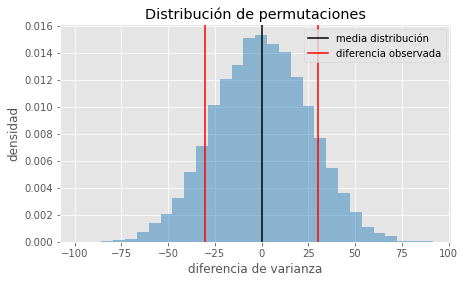

In [26]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de varianza')
ax.set_ylabel('densidad')
ax.legend()

In [27]:
pd.Series(dist_permut).describe()

count    9999.000000
mean        0.156772
std        25.202557
min       -98.293621
25%       -17.298081
50%        -0.048790
75%        17.815931
max        91.585461
dtype: float64

In [28]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.23522352235223523
p-value con corrección: 0.23532353235323533


In [29]:
# Datos
# ==============================================================================
# De los 90 individuos hay 50 control y 40 tratados.
control     = np.array(11 * [True] +  39 * [False])
tratamiento = np.array(14 * [True] +  26 * [False])

In [30]:
dif_observada = dif_mean(
                    x1 = control,
                    x2 = tratamiento
                )
print(f"Diferencia observada: {dif_observada}")

Diferencia observada: -0.12999999999999998


In [32]:
dist_permut = permutaciones(
                x1 = control,
                x2 = tratamiento,
                fun_estadistico = dif_mean,
                n_iteraciones   = 9999
              )

100%|██████████| 9999/9999 [00:00<00:00, 45948.44it/s]


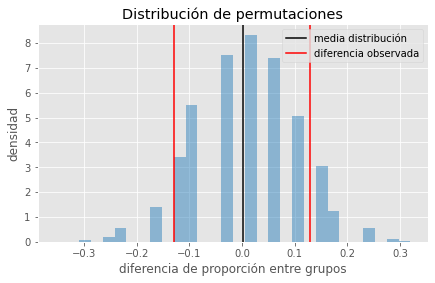

In [33]:
# Distribución de permutaciones
# ==============================================================================
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,4))
ax.hist(dist_permut, bins=30, density=True, color='#3182bd', alpha=0.5)
ax.axvline(x=dist_permut.mean(), color='black', label='media distribución')
ax.axvline(x=dif_observada, color='red', label='diferencia observada')
ax.axvline(x=-dif_observada, color='red')

ax.set_title('Distribución de permutaciones')
ax.set_xlabel('diferencia de proporción entre grupos')
ax.set_ylabel('densidad')
ax.legend()

In [34]:
pd.Series(dist_permut).describe()

count    9999.000000
mean        0.001553
std         0.095593
min        -0.355000
25%        -0.085000
50%         0.005000
75%         0.050000
max         0.320000
dtype: float64

In [37]:
# P-value empírico con y sin corrección
# ==============================================================================
p_value = (sum(np.abs(dist_permut) > np.abs(dif_observada)))/len(dist_permut)
p_value_correc = (sum(np.abs(dist_permut) > np.abs(dif_observada)) + 1)/len(dist_permut + 1)
print(f"p-value sin corrección: {p_value}")
print(f"p-value con corrección: {p_value_correc}")

p-value sin corrección: 0.1621162116211621
p-value con corrección: 0.1622162216221622
